# Loading Stuff

## Load Libraries

In [1]:
import networkx as nx
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.clique import find_cliques
import pandas as pd
import numpy as np
import time
import json
from functools import reduce
from csv import writer
import os
PATH_ROOT = os.getcwd().replace("\\","/").replace("/notebooks","")

## Load Util Functions

In [2]:
# to_verify: list to be checked where if each element is in verify_list
# verify_list: list to be checked against
# min_verify_count: the minimum amount of elements in to_verify that needs to 
# be in verify_list in order for to_verify to be considered verifiable
def is_verifiable(to_verify,verify_list,min_verify_count):
  count = 0
  for node in to_verify:
    if node in verify_list:
      count += 1
  return count >= min_verify_count

def read_json_from(path):
  with open(path, "r") as read_file:
    return json.load(read_file)

def write_json_to(json_dict,path):
  json_to_write = json.dumps(json_dict)
  write_file = open(path,"w")
  write_file.write(json_to_write)
  write_file.close()

proteomeHD_majority_to_simplified_lookup_json_path = f"{PATH_ROOT}/data_sources/ProteomeHD/majority_to_simplfied_lookup.json"
proteomeHD_majority_to_simplified_lookup_json = read_json_from(proteomeHD_majority_to_simplified_lookup_json_path)

def append_to_csv(file_name,column_names,cor_tuples):
  with open(file_name, 'a+', newline='') as write_obj:
    csv_writer = writer(write_obj)
    if column_names is not None:
      csv_writer.writerow(column_names)
    for cor_tuple in cor_tuples:
      csv_writer.writerow(cor_tuple)

def convert_majority_id_to_simplfied(graph,to_convert):
  return list(map(lambda x: proteomeHD_majority_to_simplified_lookup_json[x],to_convert))

# remove cliques that contain the same node more than once
def clean_clique(clique_list):
  return list(filter(lambda x: len(set(x)) == len(x),clique_list))

def find_cliques_of_size_k(cliques,k):
  return list(filter(lambda x: len(x) == k ,cliques))

def check_contains(subunit,clique):
  return len(np.intersect1d(clique,subunit)) > 0

def partition_cliques_by_size(cliques):
  counter = {}
  for clique in cliques:
    try:
      counter[len(clique)].append(clique)
    except KeyError:
      counter[len(clique)] = [clique]
  return counter

## Load Data

In [3]:
corum_complexes_path = f"{PATH_ROOT}/data_sources/Corum/allComplexes.txt"
all_corum_complex_pairs_json_path = f"{PATH_ROOT}/data_sources/Corum/all_corum_complex_pairs.json"

corum_complexes_dataframe = pd.read_csv(corum_complexes_path,sep='\t')
all_corum_subunits = corum_complexes_dataframe["subunits(UniProt IDs)"].to_numpy()
all_corum_subunits_list = list(map(lambda x: x.split(";"), all_corum_subunits))
all_corum_complexes_id = corum_complexes_dataframe["ComplexID"].to_numpy()

corum_complex_pairs_lookup_dict = read_json_from(all_corum_complex_pairs_json_path)
all_unique_corum_proteins = list(corum_complex_pairs_lookup_dict.keys())

protein_to_included_complex_id_path = f"{PATH_ROOT}/data_sources/Corum/protein_to_included_complex_id.json"
protein_to_included_complex_id_json = read_json_from(protein_to_included_complex_id_path)

proteomeHD_uniprot_to_idx_lookup_json_path = f"{PATH_ROOT}/data_sources/ProteomeHD/uniprot_id_idx_lookup.json"
proteomeHD_uniprot_to_idx_lookup_json = read_json_from(proteomeHD_uniprot_to_idx_lookup_json_path)

proteomeHD_verifiable_corum_complexes_amount_json_path = f"{PATH_ROOT}/data_sources/Corum/proteomeHD_verifiable_complexes_amount.json"
proteomeHD_verifiable_corum_complexes_amount_json = read_json_from(proteomeHD_verifiable_corum_complexes_amount_json_path)

def is_corum_verifiable(to_verify):
  return is_verifiable(to_verify,corum_complex_pairs_lookup_dict.keys(),len(to_verify))

def is_proteomeHD_verifiable(subunits,min_count=2):
  return is_verifiable(subunits.split(";"),proteomeHD_uniprot_to_idx_lookup_json.keys(),min_count)

all_proteomeHD_verifiable_corum_subunits = list(filter(lambda x: is_proteomeHD_verifiable(x), all_corum_subunits))

## Loads the network and print number of nodes and edges. (For large network like ppa_r_050_obs_5.graphml (531mb) this takes about 2 minutes)

In [18]:
# Loads network data from graphml
# Warning: Node attributes will be string
graph_input_path = f"{PATH_ROOT}/graph_outputs/graphml_graph_corum_only_no_ribosome/r_75_obs_100.graphml"
ppa_graph = nx.read_graphml(graph_input_path)

# Remove isolated nodes
isolated = list(nx.isolates(ppa_graph))
ppa_graph.remove_nodes_from(isolated)
print(f"Number of nodes: {ppa_graph.number_of_nodes()}")
print(f"Number of edges: {ppa_graph.number_of_edges()}")

Number of nodes: 724
Number of edges: 3612


Finding cliques in network

In [19]:
all_cliques = list(nx.enumerate_all_cliques(ppa_graph))
print(f"Number of cliques in network: {len(all_cliques)}")

Number of cliques in network: 6719111


In [9]:
all_cliques

[['O00151'],
 ['Q06187;Q06187-2'],
 ['O00161;O00161-2'],
 ['P04899;P04899-6;P04899-5;P04899-2'],
 ['P50148'],
 ['P60953'],
 ['P61224;P61224-3;A6NIZ1;P61224-2'],
 ['P62873;P62873-2'],
 ['P62879'],
 ['P63218'],
 ['Q13094'],
 ['Q86UX7-2;Q86UX7'],
 ['Q96CW1'],
 ['Q9Y490'],
 ['O00217'],
 ['P17568'],
 ['O00425'],
 ['Q9NZI8;Q9NZI8-2'],
 ['O14979'],
 ['P22626'],
 ['P52272;P52272-2'],
 ['P62304'],
 ['P62318-2;P62318'],
 ['P84090'],
 ['Q13148'],
 ['Q14103-3;Q14103'],
 ['Q15717;Q15717-2'],
 ['O15143'],
 ['O15144'],
 ['O15145'],
 ['O15511;O15511-2'],
 ['P61160;P61160-2'],
 ['Q7L576'],
 ['P59998;P59998-3'],
 ['O15270'],
 ['Q00013;Q00013-2'],
 ['O15400-2;O15400'],
 ['P11166'],
 ['P11215;P11215-2'],
 ['P16150'],
 ['Q8NHG7'],
 ['Q9HBI1'],
 ['P18206-2;P18206'],
 ['P61158'],
 ['Q04917'],
 ['O43181'],
 ['O95169-3;O95169;O95169-2'],
 ['Q9P0J0;Q9P0J0-2'],
 ['O43390;O43390-3'],
 ['P09651;P09651-2;P09651-3'],
 ['P61978-3'],
 ['Q13838;Q13838-2'],
 ['O43674;O43674-2'],
 ['Q86Y39;Q86Y39-2'],
 ['O43676'],
 ['O43

Check which cliques are corum verifiable

In [20]:
all_cliques_uniprot = list(map(lambda x: convert_majority_id_to_simplfied(ppa_graph,x),all_cliques))
verifiable_cliques = list(filter(is_corum_verifiable,all_cliques_uniprot))
# We remove cliques that have the same node for more than once
# this happens when two proteomeHD entries have the same simplified protein id
verifiable_cliques = clean_clique(verifiable_cliques)
print(len(verifiable_cliques))

6587974


In [16]:
verifiable_cliques

[['O00151'],
 ['Q06187'],
 ['O00161'],
 ['P04899'],
 ['P50148'],
 ['P60953'],
 ['P61224'],
 ['P62873'],
 ['P62879'],
 ['P63218'],
 ['Q13094'],
 ['Q86UX7'],
 ['Q96CW1'],
 ['Q9Y490'],
 ['O00217'],
 ['P17568'],
 ['O00425'],
 ['Q9NZI8'],
 ['O14979'],
 ['P22626'],
 ['P52272'],
 ['P62304'],
 ['P62318'],
 ['P84090'],
 ['Q13148'],
 ['Q14103'],
 ['Q15717'],
 ['O15143'],
 ['O15144'],
 ['O15145'],
 ['O15511'],
 ['P61160'],
 ['Q7L576'],
 ['P59998'],
 ['O15270'],
 ['Q00013'],
 ['O15400'],
 ['P11166'],
 ['P11215'],
 ['P16150'],
 ['Q8NHG7'],
 ['Q9HBI1'],
 ['P18206'],
 ['P61158'],
 ['Q04917'],
 ['O43181'],
 ['O95169'],
 ['Q9P0J0'],
 ['O43390'],
 ['P09651'],
 ['P61978'],
 ['Q13838'],
 ['O43674'],
 ['Q86Y39'],
 ['O43676'],
 ['O43920'],
 ['O95167'],
 ['O43678'],
 ['O75380'],
 ['O95298'],
 ['Q9UI09'],
 ['O75489'],
 ['O75558'],
 ['P12931'],
 ['P61006'],
 ['Q13418'],
 ['O75821'],
 ['Q13347'],
 ['O75955'],
 ['Q08722'],
 ['Q14254'],
 ['O95139'],
 ['P01871'],
 ['P06396'],
 ['P02671'],
 ['P11171'],
 ['P28676'],

Check sizes

In [21]:
clique_counter = partition_cliques_by_size(verifiable_cliques)
print("Cliques that can be verified by Corum")
for key in clique_counter:
  print(f"Size {key} Cliques: {len(clique_counter[key])}")

Cliques that can be verified by Corum
Size 1 Cliques: 721
Size 2 Cliques: 3564
Size 3 Cliques: 16349
Size 4 Cliques: 64081
Size 5 Cliques: 189057
Size 6 Cliques: 428200
Size 7 Cliques: 762245
Size 8 Cliques: 1082118
Size 9 Cliques: 1234508
Size 10 Cliques: 1134517
Size 11 Cliques: 838132
Size 12 Cliques: 494389
Size 13 Cliques: 230029
Size 14 Cliques: 82793
Size 15 Cliques: 22363
Size 16 Cliques: 4319
Size 17 Cliques: 549
Size 18 Cliques: 39
Size 19 Cliques: 1


# Defining hit,precision, and recall
- hit: When the proteins in a clique is subset of a protein subunits in a protein complex in the Corum dataset
- precision: Number of hitting cliques / total number of cliques
- recall: Number of complexes hit by cliques / total number of complexes
- recall: Number of complexes hit by cliques / total number of complexes that contain at least one protein of all proteins present in cliques

In [12]:
# Checks if a given clique (tuple or list) is a hit
# When the proteins in the clique is a subset of a protein subunits in a protein
# complex in the Corum dataset
def is_hit(clique,return_complexes=False):
  shared_complexes = []
  for protein in clique:
    shared_complexes.append(protein_to_included_complex_id_json[protein])
  overlapped_complexes = reduce(np.intersect1d,shared_complexes)
  overlapped_complexes = list(map(lambda x: int(x),overlapped_complexes))
  return overlapped_complexes if return_complexes else len(overlapped_complexes) > 0
      
# Calculates the precision of the given list of cliques
# precison = number of hitting cliques / total number of cliques
def calc_precision(cliques,loud=False):
  hit_num = 0
  for clique in cliques:
    if(is_hit(clique)):
      hit_num += 1
  if loud:
    print(f"Total Number of Cliques: {len(cliques)}")
    print(f"Hitting Cliques: {hit_num}")
    print(f"Precision: {hit_num / len(cliques)}")
  return hit_num / len(cliques)

# Calculates the recall of the given cliques
# recall = Number of complexes hit by cliques / total number of candidate complexes
# candidate complexes are complexes that contain at least 1 protein listed in cliques
def calc_recall(cliques,loud=False,return_raw=False,recall_denominator="all_corum_complexes"):
  denominator = len(all_proteomeHD_verifiable_corum_subunits)
  flattened_protein_list = [item for sublist in cliques for item in sublist]
  # All the unique proteins in the cliques
  all_clique_proteins = np.unique(flattened_protein_list)

  # Find all complexes such that it contains at least of the proteins listed in cliques
  all_candidate_complexes_id = []
  for idx in range(len(corum_complexes_dataframe)):
    if len(np.intersect1d(all_clique_proteins,all_corum_subunits_list[idx])) > 0:
      all_candidate_complexes_id.append(all_corum_complexes_id[idx])
  if (recall_denominator == "complex_candidate"):
    denominator = len(all_candidate_complexes_id)
  elif (recall_denominator == "all_corum_complexes"):
    denominator = len(all_corum_subunits)
  # Find all complexes hit by cliques
  all_complexes_hit = []
  for clique in cliques:
    all_complexes_hit.append(is_hit(clique,return_complexes=True))
  flat_list = [item for sublist in all_complexes_hit for item in sublist]
  all_complexes_hit_unique = np.unique(flat_list)
  if loud:
    print(f"Total Number of Complex Hit: {len(all_complexes_hit_unique)}")
    print(f"Total Number of Complex Candidates: {len(all_candidate_complexes_id)}")
    print(f"Recall: {len(all_complexes_hit_unique) / len(all_candidate_complexes_id)}")
  if return_raw:
    all_complexes_hit_unique = list(map(lambda x: int(x),all_complexes_hit_unique))
    all_candidate_complexes_id = list(map(lambda x: int(x),all_candidate_complexes_id))
    return all_complexes_hit_unique,all_candidate_complexes_id
  return len(all_complexes_hit_unique) / denominator

# Give cliques, return all cliques that are hitting, non hitting, and the complexes
# they hit for all hitting cliques
def partition_by_hitting_status(cliques):
  hitting_cliques = []
  corresponding_complexes = []
  non_hitting_cliques = []
  for clique in cliques:
    hitting_complex = is_hit(clique,return_complexes=True)
    if (len(hitting_complex) > 0):
      hitting_cliques.append(clique)
      corresponding_complexes.append(hitting_complex)
    else:
      non_hitting_cliques.append(clique)
  return hitting_cliques,non_hitting_cliques,corresponding_complexes

def compute_cliques_info_dict(cliques,recall_denominator="all_verifiable_corum_complexes_size_adjusted"):
  info_dict = {}
  hitting,non_hitting,corr_complexes = partition_by_hitting_status(cliques)
  complex_hit,complex_candidates = calc_recall(cliques,return_raw=True)
  info_dict["total_cliques"] = len(cliques)
  info_dict['hitting_cliques'] = hitting
  info_dict['non_hitting_cliques'] = non_hitting
  info_dict['corresponding_complexes'] = list(map(list,corr_complexes))
  info_dict['precision'] = len(hitting) / len(cliques)
  info_dict['complex_hit'] = list(complex_hit)
  info_dict['complex_candidates_id'] = complex_candidates
  info_dict['recall'] = {}
  info_dict['recall']["complex_candidate"] = len(complex_hit) / len(complex_candidates)
  info_dict['recall']["all_corum_complexes"] = len(complex_hit) / len(all_corum_subunits)
  info_dict['recall']["all_verifiable_corum_complexes"] = len(complex_hit) / len(all_proteomeHD_verifiable_corum_subunits)
  try:
    denom = proteomeHD_verifiable_corum_complexes_amount_json[str(len(cliques[0]))]
    if denom > 0:
        info_dict['recall']["all_verifiable_corum_complexes_size_adjusted"] = len(complex_hit) / denom
    else:
        info_dict['recall']["all_verifiable_corum_complexes_size_adjusted"] = float("NaN")
  except KeyError:
    info_dict['recall']["all_verifiable_corum_complexes_size_adjusted"] = float("NaN")
  return info_dict

def full_report_calculation_by_size(cliques):
  clique_partition = partition_cliques_by_size(cliques)
  report_dict = {}
  for size in clique_partition:
    info_dict = compute_cliques_info_dict(clique_partition[size])
    report_dict[size] = info_dict
  return report_dict

In [22]:
full_report_dict = full_report_calculation_by_size(verifiable_cliques)

In [15]:
full_report_dict

{1: {'total_cliques': 205,
  'hitting_cliques': [['O00151'],
   ['Q06187'],
   ['O00161'],
   ['P04899'],
   ['P50148'],
   ['P60953'],
   ['P61224'],
   ['P62873'],
   ['P62879'],
   ['P63218'],
   ['Q13094'],
   ['Q86UX7'],
   ['Q96CW1'],
   ['Q9Y490'],
   ['O00217'],
   ['P17568'],
   ['O00425'],
   ['Q9NZI8'],
   ['O14979'],
   ['P22626'],
   ['P52272'],
   ['P62304'],
   ['P62318'],
   ['P84090'],
   ['Q13148'],
   ['Q14103'],
   ['Q15717'],
   ['O15143'],
   ['O15144'],
   ['O15145'],
   ['O15511'],
   ['P61160'],
   ['Q7L576'],
   ['P59998'],
   ['O15270'],
   ['Q00013'],
   ['O15400'],
   ['P11166'],
   ['P11215'],
   ['P16150'],
   ['Q8NHG7'],
   ['Q9HBI1'],
   ['P18206'],
   ['P61158'],
   ['Q04917'],
   ['O43181'],
   ['O95169'],
   ['Q9P0J0'],
   ['O43390'],
   ['P09651'],
   ['P61978'],
   ['Q13838'],
   ['O43674'],
   ['Q86Y39'],
   ['O43676'],
   ['O43920'],
   ['O95167'],
   ['O43678'],
   ['O75380'],
   ['O95298'],
   ['Q9UI09'],
   ['O75489'],
   ['O75558'],
   ['P129

In [23]:
for key in full_report_dict:
  clique_size = key
  total_cliques = full_report_dict[key]['total_cliques']
  precision = full_report_dict[key]['precision']
  recall = full_report_dict[key]['recall']['all_verifiable_corum_complexes']
  print(f"Size {clique_size} cliques total: {total_cliques}")
  print(f"Precision: {precision} Recall: {recall}")

Size 1 cliques total: 721
Precision: 1.0 Recall: 0.5456780008193364
Size 2 cliques total: 3564
Precision: 0.18967452300785634 Recall: 0.12453912331011881
Size 3 cliques total: 16349
Precision: 0.0507676310477705 Recall: 0.02580909463334699
Size 4 cliques total: 64081
Precision: 0.014138356143006507 Recall: 0.009012699713232281
Size 5 cliques total: 189057
Precision: 0.003982925784287278 Recall: 0.005735354362965997
Size 6 cliques total: 428200
Precision: 0.0010859411489957964 Recall: 0.004506349856616141
Size 7 cliques total: 762245
Precision: 0.000257135173074274 Recall: 0.0008193363375665711
Size 8 cliques total: 1082118
Precision: 4.435745454747079e-05 Recall: 0.00040966816878328555
Size 9 cliques total: 1234508
Precision: 4.0501965155349334e-06 Recall: 0.00040966816878328555
Size 10 cliques total: 1134517
Precision: 0.0 Recall: 0.0
Size 11 cliques total: 838132
Precision: 0.0 Recall: 0.0
Size 12 cliques total: 494389
Precision: 0.0 Recall: 0.0
Size 13 cliques total: 230029
Precisio

In [23]:
full_report_dict[3]

{'total_cliques': 102,
 'hitting_cliques': [['P24539', 'P06576', 'P30049'],
  ['P25788', 'P60900', 'P25787'],
  ['P25788', 'P28066', 'O00231'],
  ['P25788', 'P28066', 'P25787'],
  ['O95167', 'O43678', 'P56556'],
  ['O95167', 'Q9P0J0', 'Q9UI09'],
  ['Q4U2R6', 'Q9H0U6', 'Q9BYD3'],
  ['Q4U2R6', 'Q9H0U6', 'O75394'],
  ['Q13610', 'O76021', 'P06748'],
  ['O43181', 'P03891', 'Q9Y6M9'],
  ['O43181', 'P03891', 'Q9P0J0'],
  ['O43181', 'P03891', 'O75489'],
  ['O43181', 'P17568', 'P19404'],
  ['P62854', 'P61513', 'P62847'],
  ['Q14152', 'Q13347', 'Q9Y262'],
  ['P62333', 'P35998', 'P43686'],
  ['Q9Y2R5', 'Q9BYN8', 'Q9H2W6'],
  ['Q9Y2R5', 'Q9BYN8', 'Q9Y291'],
  ['Q9Y2R5', 'P82664', 'Q9Y291'],
  ['P06576', 'P56134', 'P48047'],
  ['Q07955', 'Q13247', 'Q01081'],
  ['Q6IAA8', 'Q9Y2Q5', 'Q9UHA4'],
  ['Q9BRX5', 'Q14691', 'Q9BRT9'],
  ['O96000', 'O95139', 'P17568'],
  ['P50990', 'P48643', 'Q99832'],
  ['O15235', 'Q9BYC9', 'Q9Y3B7'],
  ['Q96EL3', 'P82930', 'Q9BYD1'],
  ['P28331', 'O43920', 'P17568'],
  ['O0

Calculate Precision on network of different sizes

Cliques that are at least size 3

In [18]:
verifiable_minimum_size_3_cliques = list(filter(lambda x: len(x) >= 3,verifiable_cliques))

In [19]:
calc_precision(verifiable_minimum_size_3_cliques)
calc_recall(verifiable_minimum_size_3_cliques)

0.004913430042115114

Check cliques that did not hit

In [20]:
non_hitting_minimum_size_3_cliques = list(filter(lambda x: not is_hit(x),verifiable_minimum_size_3_cliques))

In [21]:
non_hitting_minimum_size_3_cliques

[['P08621',
  'P62306',
  'P22626',
  'Q01844',
  'P09651',
  'P52272',
  'P61978',
  'Q16576',
  'O14979',
  'P06454'],
 ['P08621',
  'P62306',
  'P22626',
  'Q01844',
  'P09651',
  'P52272',
  'P61978',
  'Q16576',
  'O14979',
  'P14866'],
 ['P08621',
  'P62306',
  'P22626',
  'Q01844',
  'P09651',
  'P52272',
  'P61978',
  'Q16576',
  'P84103',
  'P14866'],
 ['P08621',
  'P62306',
  'P22626',
  'Q01844',
  'P09651',
  'P52272',
  'P61978',
  'Q92841',
  'Q07955',
  'P14866',
  'O14979'],
 ['P08621',
  'P62306',
  'P22626',
  'Q01844',
  'P09651',
  'P52272',
  'P61978',
  'Q92841',
  'Q07955',
  'P14866',
  'P84103'],
 ['P08621',
  'P62306',
  'P22626',
  'Q01844',
  'P09651',
  'P52272',
  'P61978',
  'Q92841',
  'P06454',
  'O14979'],
 ['P08621',
  'P62306',
  'P22626',
  'Q01844',
  'P09651',
  'P52272',
  'Q9Y3B4',
  'O14979',
  'Q16576',
  'P06454'],
 ['P08621',
  'P62306',
  'P22626',
  'Q01844',
  'P09651',
  'P52272',
  'Q9Y3B4',
  'O14979',
  'Q16576',
  'P14866'],
 ['P0862

Do it on all verifiable cliques

In [22]:
print(f"Number of Corum verifiable cliques in this network: {len(verifiable_cliques)}")
print(f"Precision: {calc_precision(verifiable_cliques)}")
print(f"Recall (all complexes): {calc_recall(verifiable_cliques)}")
print(f"Recall (involved complexes): {calc_recall(verifiable_cliques,recall_denominator='complex_candidate')}")

Number of Corum verifiable cliques in this network: 1846
Precision: 0.07963163596966413
Recall (all complexes): 0.021759475900795508
Recall (involved complexes): 0.07045454545454545


In [23]:
calc_recall(verifiable_cliques)

0.021759475900795508

Investigate in non-hitting cliques

In [24]:
non_hitting_cliques = list(filter(lambda x: not is_hit(x),verifiable_cliques))

In [25]:
non_hitting_cliques

[['Q9BQ67', 'P13984'],
 ['P08621',
  'P62306',
  'P22626',
  'Q01844',
  'P09651',
  'P52272',
  'P61978',
  'Q16576',
  'O14979',
  'P06454'],
 ['P08621',
  'P62306',
  'P22626',
  'Q01844',
  'P09651',
  'P52272',
  'P61978',
  'Q16576',
  'O14979',
  'P14866'],
 ['P08621',
  'P62306',
  'P22626',
  'Q01844',
  'P09651',
  'P52272',
  'P61978',
  'Q16576',
  'P84103',
  'P14866'],
 ['P08621',
  'P62306',
  'P22626',
  'Q01844',
  'P09651',
  'P52272',
  'P61978',
  'Q92841',
  'Q07955',
  'P14866',
  'O14979'],
 ['P08621',
  'P62306',
  'P22626',
  'Q01844',
  'P09651',
  'P52272',
  'P61978',
  'Q92841',
  'Q07955',
  'P14866',
  'P84103'],
 ['P08621',
  'P62306',
  'P22626',
  'Q01844',
  'P09651',
  'P52272',
  'P61978',
  'Q92841',
  'P06454',
  'O14979'],
 ['P08621',
  'P62306',
  'P22626',
  'Q01844',
  'P09651',
  'P52272',
  'Q9Y3B4',
  'O14979',
  'Q16576',
  'P06454'],
 ['P08621',
  'P62306',
  'P22626',
  'Q01844',
  'P09651',
  'P52272',
  'Q9Y3B4',
  'O14979',
  'Q16576'

## Proceduraly generate network report json

In [41]:
import glob
import os

def processs_single_network_file(network_path,maximal=True):
    file_name = os.path.basename(network_path)
    params = file_name.replace(".graphml","").split("_")
    print(f"Currently Processing: {network_path}")
    dict_to_write = {}
    dict_to_write['corresponding_file_name'] = file_name
    dict_to_write['r_threshold'] = params[1]
    dict_to_write['obs_threshold'] = params[3]
    
    r_threshold = params[1]
    obs_threshold = params[3]
    write_path = f"{PATH_ROOT}/graph_outputs/graphml_graph_corum_only_no_ribosome_report_json/r_{r_threshold}_obs_{obs_threshold}.json"
    ppa_graph = nx.read_graphml(network_path)
    isolated = list(nx.isolates(ppa_graph))
    ppa_graph.remove_nodes_from(isolated)
    print("Generating Cliques...")
    if maximal:
        all_cliques = list(nx.find_cliques(ppa_graph))
    else:
        all_cliques = list(nx.enumerate_all_cliques(ppa_graph))
    print("Generating Report JSON...")
    all_cliques_uniprot = list(map(lambda x: convert_majority_id_to_simplfied(ppa_graph,x),all_cliques))
    verifiable_cliques = list(filter(is_corum_verifiable,all_cliques_uniprot))
    valid_cliques = clean_clique(verifiable_cliques)
    cliques_info_partitioned_by_size_dict = full_report_calculation_by_size(valid_cliques)
    dict_to_write['cliques_info_by_size'] = cliques_info_partitioned_by_size_dict
    write_json_to(dict_to_write,write_path)
    print("JSON report generation finished")

# Writes an report json for each network in the given directory
def process_network_files(path_to_network_directory,max_file_size=3000*1000,min_r=75,min_obs=100,maximal=True):
  skipped_files = []
  already_done = set()
  path_to_json_directory = f"{PATH_ROOT}/graph_outputs/graphml_graph_corum_only_no_ribosome_report_cummulative_json/*.json"
  for jname in glob.glob(path_to_json_directory):
    already_done.add(os.path.basename(jname).replace(".json",".graphml"))
  for fname in glob.glob(path_to_network_directory):
    file_size = os.stat(fname).st_size
    file_name = os.path.basename(fname)
    params = file_name.replace(".graphml","").split("_")
    r_threshold = int(params[1])
    obs_threshold = int(params[3])
    if (file_size <= max_file_size and r_threshold >= min_r and obs_threshold >= min_obs and file_name not in already_done):
#         print(file_name)
#         print(file_size)
#         print(r_threshold)
#         print(obs_threshold)
        processs_single_network_file(fname,maximal)
    else:
        skipped_files.append(file_name)
  print("All file processed")
  print(f"Skipped Files: {str(skipped_files)}")
  

In [ ]:
processs_single_network_file(f"{PATH_ROOT}/graph_outputs/graphml_graph_corum_only_no_ribosome/r_75_obs_60.graphml")

Currently Processing: D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/graph_outputs/graphml_graph_corum_only_no_ribosome/r_75_obs_60.graphml
Generating Cliques...


In [54]:
graphml_graph_direcotry_path = f"{PATH_ROOT}/graph_outputs/graphml_graph_corum_only_no_ribosome/*.graphml"
process_network_files(graphml_graph_direcotry_path,15000*1000,0,0)

Currently Processing: D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/graph_outputs/graphml_graph_corum_only_no_ribosome\r_055_obs_100.graphml
Generating Cliques...
Generating Report JSON...
JSON report generation finished
Currently Processing: D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/graph_outputs/graphml_graph_corum_only_no_ribosome\r_055_obs_110.graphml
Generating Cliques...
Generating Report JSON...
JSON report generation finished
Currently Processing: D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/graph_outputs/graphml_graph_corum_only_no_ribosome\r_055_obs_120.graphml
Generating Cliques...
Generating Report JSON...
JSON report generation finished
Currently Processing: D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/graph_outputs/graphml_graph_corum_only_no_ribosome\r_055_obs_130.graphml
Generati

Generating Cliques...
Generating Report JSON...
JSON report generation finished
Currently Processing: D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/graph_outputs/graphml_graph_corum_only_no_ribosome\r_06_obs_100.graphml
Generating Cliques...
Generating Report JSON...
JSON report generation finished
Currently Processing: D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/graph_outputs/graphml_graph_corum_only_no_ribosome\r_06_obs_110.graphml
Generating Cliques...
Generating Report JSON...
JSON report generation finished
Currently Processing: D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/graph_outputs/graphml_graph_corum_only_no_ribosome\r_06_obs_120.graphml
Generating Cliques...
Generating Report JSON...
JSON report generation finished
Currently Processing: D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/grap

Generating Cliques...
Generating Report JSON...
JSON report generation finished
Currently Processing: D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/graph_outputs/graphml_graph_corum_only_no_ribosome\r_07_obs_80.graphml
Generating Cliques...
Generating Report JSON...
JSON report generation finished
Currently Processing: D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/graph_outputs/graphml_graph_corum_only_no_ribosome\r_07_obs_90.graphml
Generating Cliques...
Generating Report JSON...
JSON report generation finished
Currently Processing: D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/graph_outputs/graphml_graph_corum_only_no_ribosome\r_085_obs_100.graphml
Generating Cliques...
Generating Report JSON...
JSON report generation finished
Currently Processing: D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/graph

JSON report generation finished
Currently Processing: D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/graph_outputs/graphml_graph_corum_only_no_ribosome\r_095_obs_60.graphml
Generating Cliques...
Generating Report JSON...
JSON report generation finished
Currently Processing: D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/graph_outputs/graphml_graph_corum_only_no_ribosome\r_095_obs_70.graphml
Generating Cliques...
Generating Report JSON...
JSON report generation finished
Currently Processing: D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/graph_outputs/graphml_graph_corum_only_no_ribosome\r_095_obs_80.graphml
Generating Cliques...
Generating Report JSON...
JSON report generation finished
Currently Processing: D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/graph_outputs/graphml_graph_corum_only_no_ribosome\r

## Analyze Precision of clique of size n with different r and obs threshold

In [27]:
graphml_graph_report_json_direcotry_path = f"{PATH_ROOT}/graph_outputs/graphml_graph_corum_only_no_ribosome_report_json/*.json"
size = 3
r_thresh_list = []
obs_thresh_list = []
precision_list = []
recall_size_adjusted_list = []
for fname in glob.glob(graphml_graph_report_json_direcotry_path):
    cur_report_json = read_json_from(fname)
    r_thresh_list.append(cur_report_json["r_threshold"])
    obs_thresh_list.append(cur_report_json["obs_threshold"])
#     print(cur_report_json["cliques_info_by_size"].keys())
#     break
    try:
        clique_info_size_dict = cur_report_json["cliques_info_by_size"][str(size)]
        precision_list.append(clique_info_size_dict["precision"])
        recall_size_adjusted_list.append(clique_info_size_dict["recall"]["all_verifiable_corum_complexes"])
    except KeyError:
        precision_list.append(float('NaN'))
        recall_size_adjusted_list.append(float('NaN'))

In [29]:
r_axis = np.array(list(range(70,96,5)))
obs_axis = np.array(list(range(50,151,10)))
precision_heatmap_mat = np.zeros(shape=(len(obs_axis),len(r_axis)))
precision_heatmap_mat[np.where(precision_heatmap_mat == 0)] = float('NaN')
recall_heatmap_mat = np.zeros(shape=(len(obs_axis),len(r_axis)))
recall_heatmap_mat[np.where(recall_heatmap_mat == 0)] = float('NaN')
for idx in range(len(precision_list)):
    corr_r = int(r_thresh_list[idx])
    corr_obs = int(obs_thresh_list[idx])
    mat_col = np.where(r_axis == corr_r)[0][0]
    mat_row = np.where(obs_axis == corr_obs)[0][0]
    precision_heatmap_mat[mat_row,mat_col] = precision_list[idx]
    recall_heatmap_mat[mat_row,mat_col] = recall_size_adjusted_list[idx]
precision_heatmap_df = pd.DataFrame(precision_heatmap_mat,index=obs_axis,columns=r_axis/100)
recall_heatmap_df = pd.DataFrame(recall_heatmap_mat,index=obs_axis,columns=r_axis/100)

In [31]:
precision_heatmap_df

,0.70,0.75,0.80,0.85,0.90,0.95
50,0.076046,0.081683,0.109890,0.306452,0.166667,0.0
60,0.079208,0.081761,0.105590,0.285714,0.179487,0.0
70,0.101124,0.097015,0.114094,0.320000,0.250000,NaN
80,0.112735,0.138655,0.105263,0.433962,0.259259,NaN
90,0.113490,0.126829,0.127451,0.425532,0.388889,NaN
100,0.140957,0.183908,0.163043,0.452381,0.352941,NaN
110,0.134831,0.185185,0.126582,0.428571,0.400000,NaN
120,0.161049,0.222222,0.211111,0.405405,0.333333,NaN
130,0.183673,0.178571,0.175676,0.176471,0.384615,NaN
140,0.192661,0.227273,0.092593,0.214286,0.384615,NaN


D:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(0, 11)

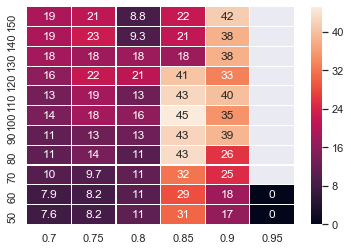

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
ax1 = sns.heatmap(precision_heatmap_df*100,annot=True,linewidths=0.1)
ax1.set_ylim([0,11])

(0, 11)

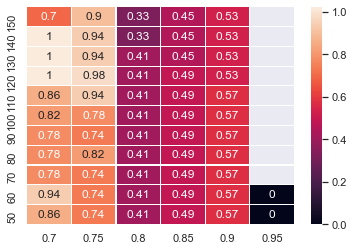

In [32]:
ax2 = sns.heatmap(recall_heatmap_df*100,annot=True,linewidths=0.1)
ax2.set_ylim([0,11])

## Fix r and obs, analyze impact of clique size on precision

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_clique_info_by_size(r_threshold,co_occurrence_threshold,get_info="precision"):
    file_name = f"{PATH_ROOT}/graph_outputs/graphml_graph_corum_only_no_ribosome_report_json/r_{r_threshold}_obs_{co_occurrence_threshold}.json"
    report_json = read_json_from(file_name)
    cliques_info_by_size = report_json["cliques_info_by_size"]
    tuple_list = []
    for size in cliques_info_by_size:
        info = cliques_info_by_size[size]["precision"]
        if get_info == "recall_size_adjusted":
            info = cliques_info_by_size[size]["recall"]["all_verifiable_corum_complexes_size_adjusted"]
        elif get_info == "recall_verifiable":
            info = cliques_info_by_size[size]["recall"]["all_verifiable_corum_complexes"]
        tuple_list.append((int(size),info,cliques_info_by_size[size]["total_cliques"]))
    tuple_list = sorted(tuple_list, key=lambda x: x[0])
    return tuple_list

# def get_clique_info_by_size_cummulative(r_threshold,co_occurrence_threshold):
#     file_name = f"{PATH_ROOT}/graph_outputs/graphml_graph_corum_only_no_ribosome_report_json/r_{r_threshold}_obs_{co_occurrence_threshold}.json"
#     report_json = read_json_from(file_name)
#     cliques_info_by_size = report_json["cliques_info_by_size"]
#     tuple_list = []
            

D:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


   Clique Sizes  Precision  Total Cliques
0             2   0.333333             48
1             3   0.222222             27
2             4   0.178571             28
3             5   0.000000              4
4             6   0.000000              5
5             7   0.000000              5
6             8   0.000000              1


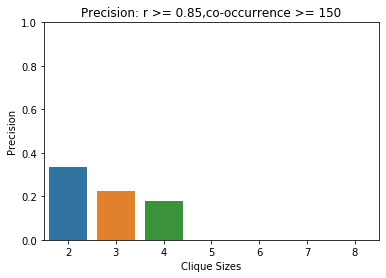

In [27]:
r_to_test = 85
obs_to_test = 150
precision_tuple_list = get_clique_info_by_size(r_to_test,obs_to_test)
precision_visualize_df = pd.DataFrame(precision_tuple_list,columns=["Clique Sizes","Precision","Total Cliques"])
ax = sns.barplot(x="Clique Sizes",y="Precision",data=precision_visualize_df)
plt.ylim(0,1)
plt.title(f"Precision: r >= {r_to_test/100},co-occurrence >= {obs_to_test}")
print(precision_visualize_df)

# Cummulative Version

    Clique Sizes  Recall(Verifiable Only)  Total Cliques
0              2                 0.020483            327
1              3                 0.006357             75
2              4                 0.002481             38
3              5                 0.001802             37
4              6                 0.004717             32
5              7                 0.000000             22
6              8                 0.003497             27
7              9                 0.000000             19
8             10                 0.000000             25
9             11                 0.013793             24
10            12                 0.008197             10
11            13                 0.019802              9
12            14                 0.024096              5
13            15                 0.028986              9
14            16                 0.037736              5
15            17                 0.050000             18
16            18               

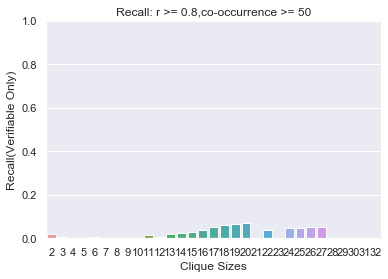

In [152]:
recall_tuple_list = get_clique_info_by_size(r_to_test,obs_to_test,"recall_size_adjusted")
recall_visualize_df = pd.DataFrame(recall_tuple_list,columns=["Clique Sizes","Recall(Verifiable Only)","Total Cliques"])
ax2 = sns.barplot(x="Clique Sizes",y="Recall(Verifiable Only)",data=recall_visualize_df)
plt.title(f"Recall: r >= {r_to_test/100},co-occurrence >= {obs_to_test}")
plt.ylim(0,1)
print(recall_visualize_df)

## Other networks